In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# DQN

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Define model
class QNetwork(nn.Module):

    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """ state_shape (int): Dimension of each state
            h1_nodes (int): Number of nodes in first hidden layer
            action_space_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
         ## add three fully connected layers using nn.Linear()
        self.fc1 = nn.Linear(state_shape, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes, h1_nodes)
        self.out = nn.Linear(h1_nodes, action_space_size) 
        


    def forward(self, state):
      # define the forward propagation  by adding the relu() activation function between layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x)) 
        return self.out(x)

In [7]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen, batch_size):
        self.memory = deque([], maxlen=maxlen)
        self.batch_size = batch_size

    def append(self, experience):
        self.memory.append(experience)

    def sample(self):
        #Randomly sample a batch of experiences from memory 
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
#Define the Deep QLearning Agent
class DQAgent():
        """Interacts with and learns from the environment."""

        def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, replay_memory_size=int(1e5),batch_size=64, UPDATE_EVERY=20, LEARN_EVERY=4, GAMMA=0.99):
           """Initialize an Agent object. """

           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.LERN_EVERY = LEARN_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate
           self.batch_size = batch_size
           self.replay_memory_size = replay_memory_size


           # Q-Network
           # create the local and the target networks
           self.local_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device) 
           self.target_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Replay memory
           self.memory = ReplayMemory( self.replay_memory_size, self.batch_size)

           # Initialize time step (for learn every LEARN_EVERY steps)
           self.l_step = 0

           # Initialize time step (for updating every UPDATE_EVERY steps)
           self.t_step = 0
            
        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          if random.random() > eps:
              Q_values = self.local_dqn(self.state_to_dqn_input(state))
              return np.argmax(Q_values.cpu().data.numpy())
                               
          else:
              return random.choice(np.arange(self.action_space_size))
              

        def step(self, state, action, reward, next_state, done):
            # Save experience in replay memory
            self.memory.append((state, action, reward, next_state, done))
            
            # If enough samples are available in memory, get random subset and learn
            self.l_step = (self.l_step + 1) % self.LERN_EVERY
            if self.l_step == 0 and len(self.memory) > self.batch_size:
                
                experiences = self.memory.sample()
                self.learn(experiences)
                
           # Copy local network to target network every UPDATE_EVERY time steps
            self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
            if self.t_step == 0:
               self.target_dqn.load_state_dict(self.local_dqn.state_dict()) 


        def learn(self, experiences):
          q_target_list = []
          q_expected_list = []
          # Obtain random minibatch of tuples from ReplayMemory
          for  state, action, reward, next_state, done in experiences:
          
             # Convert state, next_state, action abd reward to tensors 
             state = self.state_to_dqn_input(state)
             next_state = self.state_to_dqn_input(next_state)
             action=  torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
             reward = torch.from_numpy(np.array([reward])).float().unsqueeze(0).to(device)
             ## Compute and minimize the loss

             ### Extract next maximum estimated value from target network
             if(done):
               q_target = reward 
             else:
               q_target=  reward + self.GAMMA * self.target_dqn(next_state).max(1)[0]

             ### Calculate expected value from local network
             q_local = self.local_dqn(state).gather(1, action)

             q_target_list.append(q_target)
             q_expected_list.append(q_local)

          ### Loss calculation (we used Mean squared error)
          loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

In [9]:
def dqn_train(agent, n_episodes=300, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in  tqdm(range(1, n_episodes+1)):
        state = env.reset()[0]

        score = 0
        for t in range(max_t):
            # select an action
            action = agent.act(state, eps)

            #apply the selected action
            next_state, reward, done, _,_=env.step(action)
            
            # store the current experience
            agent.step(state, action, reward, next_state, done)
            

            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')
    return scores

In [10]:
env = gym.make('CartPole-v1')
print(env.reset())


print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([-0.04658439, -0.04424411, -0.04910178,  0.03047747], dtype=float32), {})
State shape:  4
Number of actions:  2


In [11]:
agent = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores = dqn_train(agent)

 17%|█████████████▌                                                                   | 50/300 [00:25<02:54,  1.43it/s]

Episode 50	Average Score: 18.84


 33%|██████████████████████████▋                                                     | 100/300 [00:46<01:17,  2.59it/s]

Episode 100	Average Score: 16.95


 50%|████████████████████████████████████████                                        | 150/300 [01:33<05:47,  2.32s/it]

Episode 150	Average Score: 24.14


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [02:55<03:06,  1.86s/it]

Episode 200	Average Score: 45.24


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [07:36<04:29,  5.40s/it]

Episode 250	Average Score: 127.69


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [14:50<00:00,  2.97s/it]

Episode 300	Average Score: 252.39


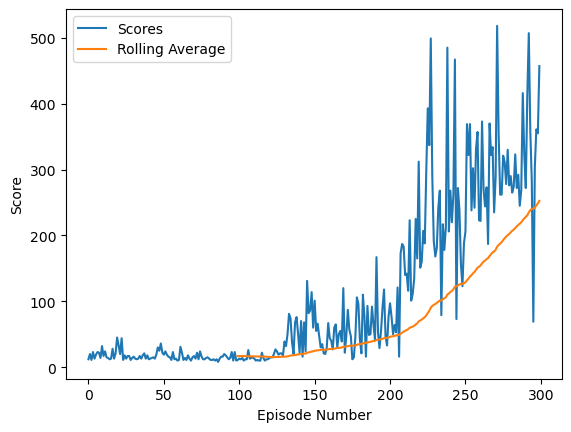

In [12]:
scores = pd.Series(scores, name="scores")
scores.describe()
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")

# DDQN

In [13]:
#Define the Deep QLearning Agent
class DDQAgent():
        """Interacts with and learns from the environment."""

        def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, replay_memory_size=int(1e5),batch_size=64, UPDATE_EVERY=20, LEARN_EVERY=4, GAMMA=0.99):
           """Initialize an Agent object. """

           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.LERN_EVERY = LEARN_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate
           self.batch_size = batch_size
           self.replay_memory_size = replay_memory_size


           # Q-Network
           # create the local and the target networks
           self.local_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)
           self.target_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Replay memory
           self.memory = ReplayMemory( self.replay_memory_size, self.batch_size)

           # Initialize time step (for learn every LEARN_EVERY steps)
           self.l_step = 0

           # Initialize time step (for updating every UPDATE_EVERY steps)
           self.t_step = 0
            
        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          if random.random() > eps:
              Q_values = self.local_dqn(self.state_to_dqn_input(state))
              return np.argmax(Q_values.cpu().data.numpy())
                               
          else:
              return random.choice(np.arange(self.action_space_size))
              

        def step(self, state, action, reward, next_state, done):
            # Save experience in replay memory
            self.memory.append((state, action, reward, next_state, done))
            
            # If enough samples are available in memory, get random subset and learn
            self.l_step = (self.l_step + 1) % self.LERN_EVERY
            if self.l_step == 0 and len(self.memory) > self.batch_size:
                
                experiences = self.memory.sample()
                self.learn(experiences)
                
           # Copy local network to target network every UPDATE_EVERY time steps
            self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
            if self.t_step == 0:
               self.target_dqn.load_state_dict(self.local_dqn.state_dict()) 


        def learn(self, experiences):
          q_target_list = []
          q_expected_list = []
          # Obtain random minibatch of tuples from ReplayMemory
          for  state, action, reward, next_state, done in experiences:
          
             # Convert state, next_state, action abd reward to tensors 
             state = self.state_to_dqn_input(state)
             next_state = self.state_to_dqn_input(next_state)
             action=  torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
             reward = torch.from_numpy(np.array([reward])).float().unsqueeze(0).to(device)
             ## Compute and minimize the loss

             ### Extract next maximum estimated value from target network
             if(done):
               q_target = reward 
             else:
                 best_action = self.local_dqn(next_state).argmax(1).unsqueeze(1)
                 q_target = reward + self.GAMMA * self.target_dqn(next_state).gather(1, best_action).squeeze(1)

             ### Calculate expected value from local network
             q_local = self.local_dqn(state).gather(1, action)

             q_target_list.append(q_target)
             q_expected_list.append(q_local)

          ### Loss calculation (we used Mean squared error)
          loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

In [14]:
def ddqn_train(agent, n_episodes=300, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in  tqdm(range(1, n_episodes+1)):
        state = env.reset()[0]

        score = 0
        for t in range(max_t):
            # select an action
            action = agent.act(state, eps)

            #apply the selected action
            next_state, reward, done, _,_=env.step(action)
            
            # store the current experience
            agent.step(state, action, reward, next_state, done)
            

            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')
    return scores

In [15]:
env = gym.make('CartPole-v1')
print(env.reset())


print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([ 0.03063362,  0.00913516, -0.00803894,  0.00990238], dtype=float32), {})
State shape:  4
Number of actions:  2


In [16]:
agent = DDQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores = ddqn_train(agent)

 17%|█████████████▌                                                                   | 50/300 [00:32<02:20,  1.77it/s]

Episode 50	Average Score: 22.06


 33%|██████████████████████████▋                                                     | 100/300 [00:59<01:52,  1.78it/s]

Episode 100	Average Score: 19.59


 50%|████████████████████████████████████████                                        | 150/300 [02:10<05:26,  2.18s/it]

Episode 150	Average Score: 30.79


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [05:28<11:30,  6.90s/it]

Episode 200	Average Score: 83.51


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [12:54<07:39,  9.19s/it]

Episode 250	Average Score: 199.96


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [19:56<00:00,  3.99s/it]

Episode 300	Average Score: 268.91


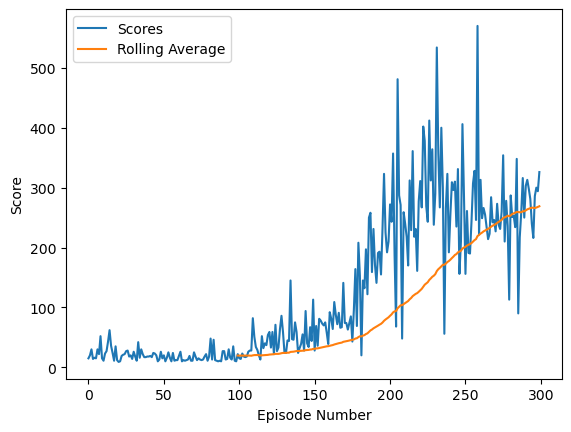

In [17]:
scores = pd.Series(scores, name="scores")
scores.describe()
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")

# DDQN SpaceInvaders

In [40]:
from ale_py import ALEInterface
ale = ALEInterface()
import ale_py
import time
from collections import deque
from IPython.display import clear_output
import math


%matplotlib inline

In [41]:
gym.register_envs(ale_py)

env = gym.make('ALE/SpaceInvaders-v5', render_mode="rgb_array")
obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
env.close()

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


The size of frame is:  (210, 160, 3)
No. of Actions:  6


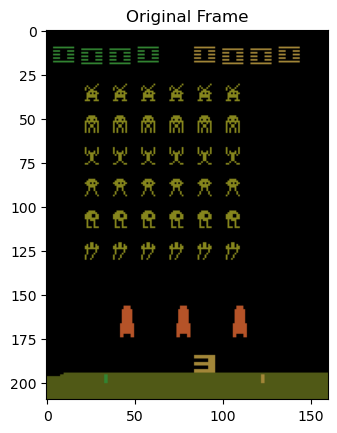

In [43]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset()[0])
plt.title('Original Frame')
plt.show()

In [44]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, truncated, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  100.0


In [45]:
import numpy as np
import cv2

def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

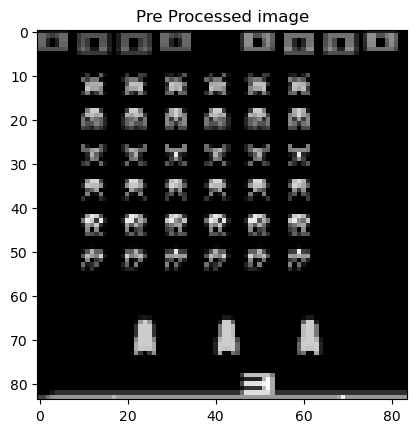

In [46]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset()[0], (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

In [47]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

In [48]:
import torch
import torch.nn as nn
import torch.autograd as autograd 
import torch.nn.functional as F


class DDQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DDQNCnn, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage  - advantage.mean()
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

In [49]:
import numpy as np
import random
from collections import namedtuple, deque
import torch

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (string): GPU or CPU
        """

        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [50]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import random

class DDQNAgent():
    def __init__(self, input_shape, action_size, seed, device, buffer_size, batch_size, gamma, lr, tau, update_every, replay_after, model):
        """Initialize an Agent object.
        
        Params
        ======
            input_shape (tuple): dimension of each state (C, H, W)
            action_size (int): dimension of each action
            seed (int): random seed
            device(string): Use Gpu or CPU
            buffer_size (int): replay buffer size
            batch_size (int):  minibatch size
            gamma (float): discount factor
            lr (float): learning rate 
            update_every (int): how often to update the network
            replay_after (int): After which replay to be started
            model(Model): Pytorch Model
        """
        self.input_shape = input_shape
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.replay_after = replay_after
        self.DQN = model
        self.tau = tau

        
        # Q-Network
        self.policy_net = self.DQN(input_shape, action_size).to(self.device)
        self.target_net = self.DQN(input_shape, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        # Replay memory
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, self.seed, self.device)
        
        self.t_step = 0

    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every

        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.replay_after:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from policy model
        Q_expected_current = self.policy_net(states)
        Q_expected = Q_expected_current.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_net(next_states).detach().max(1)[0]
        
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.policy_net, self.target_net, self.tau)

    
    # θ'=θ×τ+θ'×(1−τ)
    def soft_update(self, policy_model, target_model, tau):
        for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)

In [51]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 32        # Update batch size
LR = 0.0001            # learning rate 
TAU = .1               # for soft update of target parameters
UPDATE_EVERY = 100     # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100        # Rate by which epsilon to be decayed

agent = DDQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DDQNCnn)

In [52]:
# watch an untrained agent
state = stack_frames(None, env.reset()[0], True) 
for j in range(200):
    env.render()
    action = agent.act(state, .9)
    next_state, reward, done, truncated, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

In [53]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

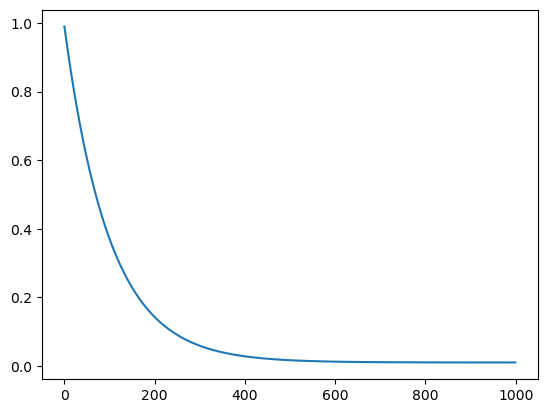

In [54]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [55]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset()[0], True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
    
    return scores

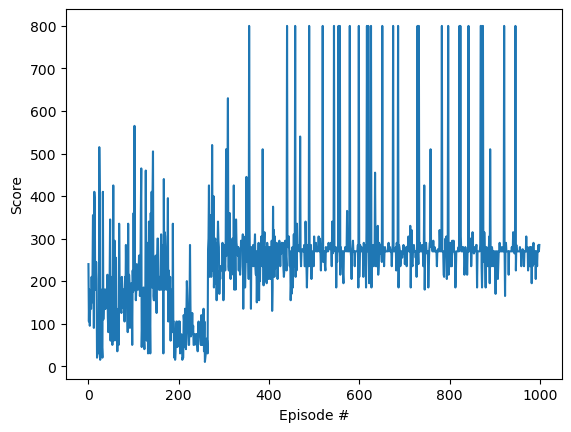

Episode 1000	Average Score: 259.75	Epsilon: 0.01

In [56]:
scores = train(1000)

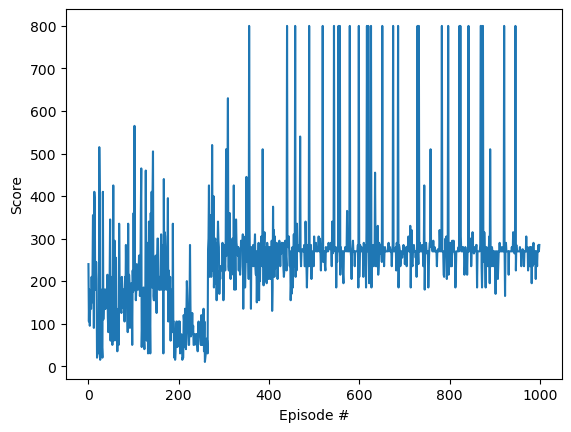

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [58]:
score = 0
state = stack_frames(None, env.reset()[0], True)
while True:
    env.render()
    action = agent.act(state, .01)
    next_state, reward, done,truncated, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

You Final score is: 280.0
